# Modeling Notebook

In this last phase, we'll load the 2 datasets prepared in the Feature Engineering phase, and implement train, and test various anomaly detection machine learning algorithms. Subsequently, we'll evaluate the performance of each algorithm by computing relevant metrics. This process will aid us in selecting the most suitable model for our specific use case.

#### Import libraries section

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.dummy import DummyClassifier

# Unsupervised
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Supervised
import sys
sys.path.append("../../venv/lib/python3.11/site-packages")
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation modules
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import make_scorer

import pickle

import warnings
warnings.filterwarnings("ignore")

### 1. Load the processed dataset

In [2]:
consolidated_df = pd.read_csv("../Data/Processed/processed_consolidated_data.csv")
filtered_df = pd.read_csv("../Data/Processed/processed_filtered_data.csv")

In [3]:
consolidated_df.head()

,cluster_6,cluster_10,cluster_15,cluster_14,cluster_4,cluster_2,cluster_17,cluster_8,cluster_12,cluster_3,cluster_9,cluster_5,cluster_1,cluster_13,cluster_0,cluster_11,cluster_7,cluster_16,anomaly
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-0.475738,0.000000,0.000000,0.0,-2.981119e-01,0.000000,0.000000,0.0,0.000000,0
1,0.000000,-0.038235,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,0.000000,0
2,1.373144,6.981317,0.0,1.181053,0.0,4.596254,6.473705,0.0,0.511663,2.330604,0.593854,-0.341399,0.0,-1.040000e-08,-0.088416,17.912556,0.0,2.593812,1
3,1.373144,6.981317,0.0,1.181053,0.0,4.596254,6.473705,0.0,0.511663,2.330604,0.593854,-0.341399,0.0,-1.040000e-08,-0.088416,17.912556,0.0,2.593812,1
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-0.160446,0.000000,0.000000,0.0,0.000000e+00,-0.088416,0.000000,0.0,0.000000,1


In [4]:
filtered_df.head()

,Assets,EarningsPerShareBasic,NetIncomeLoss,RetainedEarningsAccumulatedDeficit,StockholdersEquity,anomaly
0,0.0,0.00000,0.0,0.0,0.0,0
1,0.0,0.00000,0.0,0.0,0.0,0
2,0.0,0.38838,0.0,0.0,0.0,1
3,0.0,0.38838,0.0,0.0,0.0,1
4,0.0,0.00000,0.0,0.0,0.0,1


### 2. Train and test split and validations
In this section, we will divide our data in train and test splits so we can train and validate our machine learning models' performances and run the last validations before inputting the data in our models

In [5]:
# Ensure there are no duplicates
print("Number of duplicates in consolidated_df:", consolidated_df.duplicated().sum())
consolidated_df = consolidated_df.drop_duplicates()
# Ensure there are no duplicates
print("Number of duplicates in filtered_df:", filtered_df.duplicated().sum())
filtered_df = filtered_df.drop_duplicates()

# Ensure there are no full null rows
mask = (consolidated_df.iloc[:,:-1] == 0).all(axis=1)
print("Number of full Null rows in inputs:", mask.sum())
consolidated_df = consolidated_df[~mask]
mask = (filtered_df.iloc[:,:-1] == 0).all(axis=1)
print("Number of full Null rows in inputs:", mask.sum())
filtered_df = filtered_df[~mask]

Number of duplicates in consolidated_df: 604
Number of duplicates in filtered_df: 1719
Number of full Null rows in inputs: 2
Number of full Null rows in inputs: 2


In [6]:
# (1) Consolidated dataset

# Define features and target
X_consolidated = consolidated_df.drop(columns=['anomaly'])
y_consolidated = consolidated_df['anomaly']

# Split the data into training and testing sets
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_consolidated, y_consolidated, test_size=0.3, random_state=42, stratify=y_consolidated)

In [7]:
# (2) Filtered dataset

# Define features and target
X_filtered = filtered_df.drop(columns=['anomaly'])
y_filtered = filtered_df['anomaly']

# Split the data into training and testing sets
X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)

### 3. Modelling

In this section, we will try different machine learning models to build our anomaly detector and select the best performer. Initially, we'll start with a Dummy Classifier as a baseline to provide a benchmark for comparison. Following this, we will use Unsupervised and Supervised models.

Unsupervised:
1. IsolationForest
2. One-Class SVM

Supervised:
1. Random Forest Classifier
2. Gradient Boosting

Deep Learning:
1. Neural Networks (AutoEncoder)

For each preprocessed dataset and model, we'll perform hyperparameter tuning using RandomizedSearchCV to find the best configuration. We evaluate each model using accuracy, confusion matrix, and classification report to understand their performance. Finally, we identify the best performing pair (model, dataset) based on recall and save it to a pickle file for future use. Additionally, we visualize the confusion matrices for the top models to inspect their performance further.

In [8]:
# Storing the files
results_list = []

#### 3.1 Dummy Classifier
This is our benchmark model

In [9]:
# (1) Consolidated dataset

# Instantiate and fit a dummy classifier (e.g., most frequent strategy)
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_con, y_train_con)

# Predict on test set
y_pred_dummy = dummy_clf.predict(X_test_con)

results_dict = {"Model":"Dummy Classifier", 
                "Dataset":"Consolidated",
                "Accuracy":accuracy_score(y_test_con, y_pred_dummy), 
                "Recall":recall_score(y_test_con, y_pred_dummy)}

results_list.append(results_dict)

print("Dummy Classifier:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_dummy)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_dummy)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_dummy, zero_division=0)}")

Dummy Classifier:
Accuracy: 0.9111709286675639

Confusion Matrix:
[[1354    0]
 [ 132    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1354
           1       0.00      0.00      0.00       132

    accuracy                           0.91      1486
   macro avg       0.46      0.50      0.48      1486
weighted avg       0.83      0.91      0.87      1486


In [10]:
# (2) Filtered dataset

# Instantiate and fit a dummy classifier (e.g., most frequent strategy)
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_filter, y_train_filter)

# Predict on test set
y_pred_dummy = dummy_clf.predict(X_test_filter)


results_dict = {"Model":"Dummy Classifier", 
                "Dataset":"Filtered",
                "Accuracy":accuracy_score(y_test_filter, y_pred_dummy), 
                "Recall":recall_score(y_test_filter, y_pred_dummy)}

results_list.append(results_dict)

print("Dummy Classifier:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_dummy)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_dummy)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_dummy, zero_division=0)}")

Dummy Classifier:
Accuracy: 0.9097222222222222

Confusion Matrix:
[[1048    0]
 [ 104    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1048
           1       0.00      0.00      0.00       104

    accuracy                           0.91      1152
   macro avg       0.45      0.50      0.48      1152
weighted avg       0.83      0.91      0.87      1152


#### 3.2 Isolation Forest

##### 3.2.1 Consolidated dataset - Default settings

In [11]:
# (1) Consolidated dataset

# Instantiate Isolation Forest
iso_forest_1 = IsolationForest(contamination=0.09)  # Adjust contamination based on your anomaly rate
iso_forest_1.fit(X_train_con)

# Predict outliers/anomalies
y_pred_if = iso_forest_1.predict(X_test_con)  # Anomalies are labeled as -1, normal points as 1
y_pred_if = np.where(y_pred_if == -1, 1, 0)

print("\nIsolation Forest:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_if)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_if)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_if, zero_division=0)}")


Isolation Forest:
Accuracy: 0.8364737550471063

Confusion Matrix:
[[1228  126]
 [ 117   15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1354
           1       0.11      0.11      0.11       132

    accuracy                           0.84      1486
   macro avg       0.51      0.51      0.51      1486
weighted avg       0.84      0.84      0.84      1486


##### 3.2.2 Consolidated dataset - with RandomSeachCV

In [12]:
# Instantiate Isolation Forest
iso_forest_1 = IsolationForest(contamination=0.09)


param_dist_if_1 = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [False, True],
    'contamination': [0.25,0.35,0.4, 0.45] 
}


# Hyperparameter tunning
random_search_if_1 = RandomizedSearchCV(iso_forest_1,  param_distributions=param_dist_if_1, n_iter=50, cv=5, scoring='recall', random_state=42, n_jobs=-1)
random_search_if_1.fit(X_train_con)


best_if_clf_1 = random_search_if_1.best_estimator_
y_pred_best_if_1 = best_if_clf_1.predict(X_test_con)
y_pred_best_if_1 = np.where(y_pred_best_if_1 == -1, 1, 0)  # Convert -1 (anomaly) to 1, and 1 (normal) to 0

results_dict = {"Model":" Isolation Forest with RandomizedSearchCV", 
                "Dataset":"Consolidated",
                "Accuracy":accuracy_score(y_test_con, y_pred_best_if_1), 
                "Recall":recall_score(y_test_con, y_pred_best_if_1)}

results_list.append(results_dict)


print("\nBest Isolation Forest:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_best_if_1)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_best_if_1)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_best_if_1, zero_division=0)}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa


Best Isolation Forest:
Accuracy: 0.5390309555854643

Confusion Matrix:
[[754 600]
 [ 85  47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69      1354
           1       0.07      0.36      0.12       132

    accuracy                           0.54      1486
   macro avg       0.49      0.46      0.40      1486
weighted avg       0.83      0.54      0.64      1486


##### 3.2.1 Filtered dataset - Default Settings

In [13]:
# (2) Filtered dataset

# Instantiate Isolation Forest
iso_forest_2 = IsolationForest(contamination=0.09)  # Adjust contamination based on your anomaly rate
iso_forest_2.fit(X_train_filter)

# Predict outliers/anomalies
y_pred_if = iso_forest_2.predict(X_test_filter)  # Anomalies are labeled as -1, normal points as 1
y_pred_if = np.where(y_pred_if == -1, 1, 0)

print("\nIsolation Forest:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_if)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_if)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_if, zero_division=0)}")


Isolation Forest:
Accuracy: 0.8420138888888888

Confusion Matrix:
[[950  98]
 [ 84  20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1048
           1       0.17      0.19      0.18       104

    accuracy                           0.84      1152
   macro avg       0.54      0.55      0.55      1152
weighted avg       0.85      0.84      0.85      1152


##### 3.2.2 Filtered dataset - with RandomSeachCV

In [14]:
# Instantiate Isolation Forest
iso_forest_2 = IsolationForest() # decreasing contamination to be more biased towards anomalies. old 0.09


# Hyperparameter tuning for Isoloation Forest using RandomizedSearchCV
param_dist_if_2 = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75],
    'max_features': [0.5, 0.75,1.0],
    'bootstrap': [False, True],
    'contamination': [0.25,0.35,0.4, 0.45] 
}


# Hyperparameter tunning
random_search_if_2 = RandomizedSearchCV(iso_forest_2,  param_distributions=param_dist_if_2, n_iter=50, cv=5, scoring='recall', random_state=42, n_jobs=-1)
random_search_if_2.fit(X_train_filter)


best_if_clf_2 = random_search_if_2.best_estimator_
y_pred_best_if_2 = best_if_clf_2.predict(X_test_filter)
y_pred_best_if_2 = np.where(y_pred_best_if_2 == -1, 1, 0)  # Convert -1 (anomaly) to 1, and 1 (normal) to 0

results_dict = {"Model":" Isolation Forest with RandomizedSearchCV", 
                "Dataset":"Filtered",
                "Accuracy":accuracy_score(y_test_filter, y_pred_best_if_2), 
                "Recall":recall_score(y_test_filter, y_pred_best_if_2)}

results_list.append(results_dict)

print("\nBest Isolation Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_best_if_2)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_best_if_2)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_best_if_2, zero_division=0)}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa


Best Isolation Forest Classifier:
Accuracy: 0.546875

Confusion Matrix:
[[577 471]
 [ 51  53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      1048
           1       0.10      0.51      0.17       104

    accuracy                           0.55      1152
   macro avg       0.51      0.53      0.43      1152
weighted avg       0.84      0.55      0.64      1152


#### 3.3 One-Class SVM

##### 3.3.1 Consolidated dataset - Default settings

In [15]:
# Instantiate One-Class SVM
one_class_svm_1 = OneClassSVM(nu=0.09)  # Adjust nu based on your anomaly rate

# Fit the model
one_class_svm_1.fit(X_train_con)

# Predict outliers/anomalies
y_pred_svm = one_class_svm_1.predict(X_test_con)  # Anomalies are labeled as -1, normal points as 1
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

results_dict = {"Model":" One-Class SVM with Default Settings", 
                "Dataset":"Consolidated",
                "Accuracy":accuracy_score(y_test_con, y_pred_svm), 
                "Recall":recall_score(y_test_con, y_pred_svm)}

results_list.append(results_dict)


# Evaluate the model
print("\nOne-Class SVM:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_svm)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_svm)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_svm, zero_division=0)}")


One-Class SVM:
Accuracy: 0.8378196500672948

Confusion Matrix:
[[1229  125]
 [ 116   16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1354
           1       0.11      0.12      0.12       132

    accuracy                           0.84      1486
   macro avg       0.51      0.51      0.51      1486
weighted avg       0.84      0.84      0.84      1486


##### 3.3.2 Consolidated dataset - with RandomSeachCV

ERROR: the computer couldn't run this one.

##### 3.3.1 Filtered dataset - Default settings

In [16]:
# Instantiate One-Class SVM
one_class_svm_2 = OneClassSVM(nu=0.09)  # Adjust nu based on your anomaly rate

# Fit the model
one_class_svm_2.fit(X_train_filter)

# Predict outliers/anomalies
y_pred_svm = one_class_svm_2.predict(X_test_filter)  # Anomalies are labeled as -1, normal points as 1
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Evaluate the model
print("\nOne-Class SVM:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_svm)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_svm)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_svm, zero_division=0)}")


One-Class SVM:
Accuracy: 0.8272569444444444

Confusion Matrix:
[[948 100]
 [ 99   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1048
           1       0.05      0.05      0.05       104

    accuracy                           0.83      1152
   macro avg       0.48      0.48      0.48      1152
weighted avg       0.83      0.83      0.83      1152


##### 3.3.2 Filtered dataset - with RandomSeachCV

In [17]:
# Parameter grid for One-Class SVM
param_grid = {
    'nu': [0.25,0.35, 0.45],  # Adjust based on your dataset and expected anomaly rate
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']  # Relevant for rbf, poly, and sigmoid kernels
}

# Initialize One-Class SVM
one_class_svm = OneClassSVM()

# Randomized Search CV
random_search_svm_2 = RandomizedSearchCV(estimator=one_class_svm,
                                   param_distributions=param_grid,
                                   scoring="recall",
                                   cv=5,  
                                   n_iter=20,  # Number of random combinations to try
                                   random_state=42,
                                   n_jobs=-1)  # Use all available CPU cores

# Fit Randomized Search
random_search_svm_2.fit(X_train_filter, y_train_filter)

# Predict anomalies on the test set
y_pred_svm = random_search_svm_2.predict(X_test_filter)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

results_dict = {"Model":" One-Class SVM with RandomizedSearchCV", 
                "Dataset":"Filtered",
                "Accuracy":accuracy_score(y_test_filter, y_pred_svm), 
                "Recall":recall_score(y_test_filter, y_pred_svm)}

results_list.append(results_dict)


# Evaluate the best model
print("\nBest One-Class SVM from Randomized Search:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_svm)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_svm)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_svm, zero_division=0)}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 350, in _score
 


Best One-Class SVM from Randomized Search:
Accuracy: 0.6432291666666666

Confusion Matrix:
[[699 349]
 [ 62  42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1048
           1       0.11      0.40      0.17       104

    accuracy                           0.64      1152
   macro avg       0.51      0.54      0.47      1152
weighted avg       0.85      0.64      0.72      1152


, 'weighted'].

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_

#### 3.4 RandomForest Classifier

In [18]:
# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_con_resampled, y_train_con_resampled = smote.fit_resample(X_train_con, y_train_con)
X_train_filter_resampled, y_train_filter_resampled = smote.fit_resample(X_train_filter, y_train_filter)

rk/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py", line 1556, in _check_set_wise_labels
    raise ValueError(
ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    retur

##### 3.4.1 Consolidated dataset - Default settings

In [19]:
# Instantiate Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train_con_resampled, y_train_con_resampled)

# Predict anomalies on the test set
y_pred_rf = rf_classifier.predict(X_test_con)

# Evaluate the model
print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_rf)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_rf)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_rf, zero_division=0)}")

3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py", line 1556, in _check_set_wise_labels
    raise ValueError(
ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._scor


Random Forest Classifier:
Accuracy: 0.8862718707940781

Confusion Matrix:
[[1279   75]
 [  94   38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1354
           1       0.34      0.29      0.31       132

    accuracy                           0.89      1486
   macro avg       0.63      0.62      0.62      1486
weighted avg       0.88      0.89      0.88      1486


##### 3.4.2 Consolidated dataset - with RandomSeachCV
Run on Google Colab

##### 3.4.1 Filtered dataset - Default settings

In [20]:
# Instantiate Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train_filter_resampled, y_train_filter_resampled)

# Predict anomalies on the test set
y_pred_rf = rf_classifier.predict(X_test_filter)

# Evaluate the model
print("\nRandom Forest Classifier:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_rf)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_rf)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_rf, zero_division=0)}")


Random Forest Classifier:
Accuracy: 0.8324652777777778

Confusion Matrix:
[[912 136]
 [ 57  47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1048
           1       0.26      0.45      0.33       104

    accuracy                           0.83      1152
   macro avg       0.60      0.66      0.62      1152
weighted avg       0.88      0.83      0.85      1152


##### 3.4.2 Filtered dataset - with RandomSeachCV
Run on Cloud

#### 3.5 Gradient Boosting (Xboost) 

##### 3.5.1 Consolidated dataset - Default settings

In [21]:
# Instantiate Gradient Boosting Classifier with default settings
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_classifier.fit(X_train_con_resampled, y_train_con_resampled)

# Predict anomalies on the test set
y_pred_gb = gb_classifier.predict(X_test_con)

results_dict = {"Model":"Gradient Boosting with Default Settings", 
                "Dataset":"Consolidated",
                "Accuracy":accuracy_score(y_test_con, y_pred_gb), 
                "Recall":recall_score(y_test_con, y_pred_gb)}

results_list.append(results_dict)


# Evaluate the model
print("\nGradient Boosting Classifier:")
print(f"Accuracy: {accuracy_score(y_test_con, y_pred_gb)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_con, y_pred_gb)}\n")
print(f"Classification Report:\n{classification_report(y_test_con, y_pred_gb, zero_division=0)}")


Gradient Boosting Classifier:
Accuracy: 0.7624495289367429

Confusion Matrix:
[[1085  269]
 [  84   48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1354
           1       0.15      0.36      0.21       132

    accuracy                           0.76      1486
   macro avg       0.54      0.58      0.54      1486
weighted avg       0.86      0.76      0.80      1486


##### 3.5.2 Consolidated dataset - with RandomSeachCV
Run on Google Colab

##### 3.5.1 Filtered dataset - Default settings

In [23]:
# Instantiate Gradient Boosting Classifier with default settings
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_classifier.fit(X_train_filter_resampled, y_train_filter_resampled)

# Predict anomalies on the test set
y_pred_gb = gb_classifier.predict(X_test_filter)

results_dict = {"Model":"Gradient Boosting with Default Settings", 
                "Dataset":"Filtered",
                "Accuracy":accuracy_score(y_test_filter, y_pred_gb), 
                "Recall":recall_score(y_test_filter, y_pred_gb)}

results_list.append(results_dict)

# Evaluate the model
print("\nGradient Boosting Classifier:")
print(f"Accuracy: {accuracy_score(y_test_filter, y_pred_gb)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_filter, y_pred_gb)}\n")
print(f"Classification Report:\n{classification_report(y_test_filter, y_pred_gb, zero_division=0)}")


Gradient Boosting Classifier:
Accuracy: 0.7083333333333334

Confusion Matrix:
[[754 294]
 [ 42  62]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1048
           1       0.17      0.60      0.27       104

    accuracy                           0.71      1152
   macro avg       0.56      0.66      0.54      1152
weighted avg       0.88      0.71      0.77      1152


##### 3.5.2 Filtered dataset - with RandomSeachCV
Run on Cloud

#### 3.6 Neural Network AutoEncoder

##### 3.6.1 Consolidated dataset
Run on Cloud

##### 3.6.2 Filtered dataset
Run on Cloud

### 4. Identify the best performer

In [33]:
results_df = pd.DataFrame(results_list)
results_df

,Model,Dataset,Accuracy,Recall
0,Dummy Classifier,Consolidated,0.911171,0.000000
1,Dummy Classifier,Filtered,0.909722,0.000000
2,Isolation Forest with RandomizedSearchCV,Consolidated,0.539031,0.356061
3,Isolation Forest with RandomizedSearchCV,Filtered,0.546875,0.509615
4,One-Class SVM with Default Settings,Consolidated,0.837820,0.121212
5,One-Class SVM with RandomizedSearchCV,Filtered,0.643229,0.403846
6,Gradient Boosting with Default Settings,Consolidated,0.762450,0.363636
7,Gradient Boosting with Default Settings,Filtered,0.708333,0.596154


In [34]:
results_to_add = pd.read_csv("../Data/Results/results_to_add_GoogleColab.csv")
results_to_add

,Model,Dataset,Accuracy,Recall
0,RandomForest with RandomizedSearchCV,Consolidated,0.913669,0.400000
1,Gradient Boosting with RandomizedSearchCV,Consolidated,0.906475,0.389474
2,AutoEncoder,Consolidated,0.588129,0.463158
3,RandomForest with RandomizedSearchCV,Filtered,0.880396,0.410526
4,Gradient Boosting with RandomizedSearchCV,Filtered,0.879496,0.378947
5,AutoEncoder,Filtered,0.595324,0.368421


In [35]:
results_df = pd.concat([results_df, results_to_add], ignore_index=True)
results_df["Accuracy"] = results_df["Accuracy"].apply(lambda x: round(x,2))
results_df["Recall"] = results_df["Recall"].apply(lambda x: round(x,2))

In [36]:
results_df.sort_values("Recall", ascending=False)

,Model,Dataset,Accuracy,Recall
7,Gradient Boosting with Default Settings,Filtered,0.71,0.60
3,Isolation Forest with RandomizedSearchCV,Filtered,0.55,0.51
10,AutoEncoder,Consolidated,0.59,0.46
11,RandomForest with RandomizedSearchCV,Filtered,0.88,0.41
5,One-Class SVM with RandomizedSearchCV,Filtered,0.64,0.40
8,RandomForest with RandomizedSearchCV,Consolidated,0.91,0.40
9,Gradient Boosting with RandomizedSearchCV,Consolidated,0.91,0.39
12,Gradient Boosting with RandomizedSearchCV,Filtered,0.88,0.38
13,AutoEncoder,Filtered,0.60,0.37
2,Isolation Forest with RandomizedSearchCV,Consolidated,0.54,0.36


In [37]:
results_df.to_csv("../Data/Results/model_metrics.csv",index=False)

### 5. Conclusions

Now that we have finished our model trainings and have gathered all the evaluation metrics from both this notebook and the google colab training, we are able to determine which pair: model and dataset preprocessing, works best for our case.

**For our anomaly detection project, where the primary focus is on recall, Gradient Boosting with Default Settings on the Filtered dataset is the recommended model. This model and preprocessing technique provides the highest recall (0.60), ensuring that the majority of the anomalies are detected.**

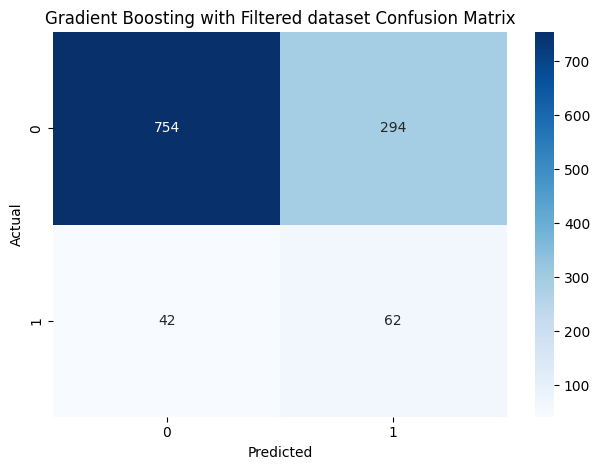

In [39]:
# Plot confusion matrice for the best model
y_pred_gb = gb_classifier.predict(X_test_filter)
cm = confusion_matrix(y_test_filter, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Gradient Boosting with Filtered dataset Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### 5. Saving the model
In this last section, we will save the best performer model into a pickle file for later usage.

In [43]:
best_model = gb_classifier

# Save the best performing model to a pickle file
pickle_file_path = '../Model/best_model.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Best model saved to {pickle_file_path}")

Best model saved to ../Model/best_model.pkl


### Notes
Run the classifier.py to test live the model.

You will need the imputer.pkl, scaler.pkl, and best_model.pkl in the Anomaly_Model/Model folder to run the script
and also your .env file updated with the current credentials.